## Import Libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time 
import joblib
import logging
import math
import pickle

from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dropout, Dense, LSTM, GRU, RNN, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
from pylab import rcParams

In [2]:
sns.set(color_codes = True)
rcParams['figure.figsize'] = 14, 8.7
col_list = ['cerulean', 'scarlet']
sns.set(style = 'white', font_scale = 1.75, palette = sns.xkcd_palette(col_list))
%matplotlib inline
tf.random.set_seed(123)
seed(123)
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
LABELS = ['Normal', 'FMA']

## GPU 

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPUs detected')

1 Physical GPUs 1 Logical GPUs


## Load Datas

In [4]:
data = pd.read_csv('../../Datasets/Dataset_Gomera_Labeled.csv', sep = ';')

In [5]:
data

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
0,22.963965,20.99,18.195237,0.0,70.0,5.1,1018.41,1017.506667,1019.283937,65.70,19572.73,26000.0,0
1,22.963965,20.99,18.195237,0.0,110.0,17.0,1018.41,1017.506667,1019.283937,65.70,60.00,1000.0,0
2,22.963965,20.99,18.195237,0.0,70.0,5.1,1018.41,1017.506667,1019.283937,65.70,240.00,3300.0,0
3,24.400000,24.40,24.400000,0.0,20.0,5.1,1016.40,1016.400000,1016.400000,60.30,22000.00,10000.0,0
4,22.963965,20.99,18.195237,0.0,110.0,5.1,1018.41,1017.506667,1019.283937,65.70,60.00,1000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4786,24.800000,23.12,21.600000,0.0,124.0,4.6,1018.90,1018.100000,1019.900000,26.22,19572.73,42500.0,0
4787,24.800000,22.50,20.800000,0.0,132.0,5.1,1018.98,1018.100000,1020.000000,29.24,19572.73,36250.0,0
4788,23.400000,22.62,21.100000,0.0,64.0,6.7,1020.14,1019.200000,1021.200000,28.50,22000.00,48750.0,0
4789,24.700000,23.06,22.000000,0.0,58.0,6.2,1023.26,1021.900000,1024.500000,19.46,22000.00,55000.0,0


In [6]:
train = data[0:math.trunc(len(data) * 0.8)]
test = data[math.trunc(len(data) * 0.8):len(data)]

In [7]:
print(data.shape)
print(train.shape)
print(test.shape)
print(train.shape[0] + test.shape[0])

(4791, 13)
(3832, 13)
(959, 13)
4791


## FMA Filter 

In [8]:
train.describe()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
count,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000,3832.000000
mean,22.960401,20.950245,18.058555,0.541675,212.785527,5.117067,1018.313781,1017.429473,1019.175925,65.808155,19053.037667,24120.222850,0.018789
std,3.177901,2.881082,2.851739,5.069986,58.217695,2.702355,3.901702,4.050892,3.945925,11.557094,4335.960779,15561.580209,0.135797
min,12.700000,12.240000,2.100000,0.000000,10.000000,0.000000,982.700000,945.800000,1000.300000,14.220000,60.000000,1000.000000,0.000000
25%,20.700000,18.697500,16.000000,0.000000,195.000000,3.600000,1016.250000,1015.500000,1017.000000,59.375000,19572.730000,12530.420000,0.000000
50%,22.963965,20.750000,18.000000,0.000000,225.225000,4.600000,1018.410000,1017.506667,1019.283937,67.455000,19572.730000,16660.000000,0.000000
75%,25.000000,23.002500,20.000000,0.000000,242.500000,6.200000,1019.950000,1019.200000,1020.800000,73.422500,22000.000000,35000.000000,0.000000
max,43.000000,36.500000,35.000000,120.500000,360.000000,43.200000,1046.700000,1046.700000,1046.700000,100.000000,22000.000000,70001.000000,1.000000


In [9]:
train = train[train['FMA'] == 0]

In [10]:
train.shape

(3760, 13)

In [11]:
split = math.trunc(train.shape[0] * 0.2)
validation = train[-split:]
train = train[:-split]

In [12]:
print("Validation:", validation.shape)
print("Train:", train.shape)

Validation: (752, 13)
Train: (3008, 13)


In [13]:
train_fma = train.iloc[:, -1]
validation_fma = validation.iloc[:, -1]
test_fma = test.iloc[:, -1]

In [14]:
train_fma.columns = ['train_fma']
validation_fma.columns = ['validation_fma']
test_fma.columns = ['test_fma']

In [15]:
test_fma.head()

3832    0
3833    0
3834    0
3835    0
3836    0
Name: FMA, dtype: int64

## Correlation

In [16]:
test.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.972920,0.881357,-0.119606,-0.047577,-0.140939,-0.363176,-0.339326,-0.382669,-0.045533,-0.033069,-0.277392,0.053806
temp_avg,0.972920,1.000000,0.952955,-0.103608,-0.081037,-0.142228,-0.374335,-0.350232,-0.393579,-0.049850,-0.046074,-0.278679,0.050791
temp_min,0.881357,0.952955,1.000000,-0.062268,-0.125131,-0.149725,-0.351670,-0.333743,-0.366080,-0.064762,-0.080751,-0.280990,0.016456
prec,-0.119606,-0.103608,-0.062268,1.000000,0.023900,0.042214,-0.239147,-0.252582,-0.219653,0.104439,-0.258816,-0.038211,0.487261
wd,-0.047577,-0.081037,-0.125131,0.023900,1.000000,-0.016725,-0.073036,-0.068943,-0.080996,0.187872,0.072266,0.085724,-0.038401
ws,-0.140939,-0.142228,-0.149725,0.042214,-0.016725,1.000000,0.042293,0.031351,0.048467,-0.045449,0.058669,-0.036188,0.498255
atmos_pres_avg,-0.363176,-0.374335,-0.351670,-0.239147,-0.073036,0.042293,1.000000,0.992758,0.993468,-0.279648,0.026159,0.183079,-0.087863
atmos_pres_min,-0.339326,-0.350232,-0.333743,-0.252582,-0.068943,0.031351,0.992758,1.000000,0.977027,-0.264295,0.036463,0.184595,-0.093571
atmos_pres_max,-0.382669,-0.393579,-0.366080,-0.219653,-0.080996,0.048467,0.993468,0.977027,1.000000,-0.290316,0.011450,0.181190,-0.075735
rh,-0.045533,-0.049850,-0.064762,0.104439,0.187872,-0.045449,-0.279648,-0.264295,-0.290316,1.000000,0.080018,-0.155158,-0.019245


In [17]:
train.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.972253,0.858020,-0.125444,0.066274,-0.084654,-0.261110,-0.223011,-0.288625,-0.066679,0.207875,-0.162673,NaN
temp_avg,0.972253,1.000000,0.930556,-0.120273,0.059542,-0.083679,-0.272722,-0.233616,-0.300403,-0.048049,0.176177,-0.139409,NaN
temp_min,0.858020,0.930556,1.000000,-0.074763,0.015059,-0.053422,-0.274624,-0.242882,-0.295744,-0.002934,0.042286,-0.050686,NaN
prec,-0.125444,-0.120273,-0.074763,1.000000,0.054333,0.189451,-0.240085,-0.244321,-0.230414,0.142776,-0.142250,-0.036000,NaN
wd,0.066274,0.059542,0.015059,0.054333,1.000000,-0.002588,-0.140491,-0.126649,-0.148036,0.362044,0.018585,0.052686,NaN
ws,-0.084654,-0.083679,-0.053422,0.189451,-0.002588,1.000000,-0.131442,-0.140164,-0.123878,-0.035096,-0.043297,-0.143020,NaN
atmos_pres_avg,-0.261110,-0.272722,-0.274624,-0.240085,-0.140491,-0.131442,1.000000,0.978526,0.977641,-0.198469,0.091130,0.154309,NaN
atmos_pres_min,-0.223011,-0.233616,-0.242882,-0.244321,-0.126649,-0.140164,0.978526,1.000000,0.915848,-0.185274,0.102387,0.137363,NaN
atmos_pres_max,-0.288625,-0.300403,-0.295744,-0.230414,-0.148036,-0.123878,0.977641,0.915848,1.000000,-0.204587,0.076958,0.163959,NaN
rh,-0.066679,-0.048049,-0.002934,0.142776,0.362044,-0.035096,-0.198469,-0.185274,-0.204587,1.000000,-0.192780,0.055487,NaN


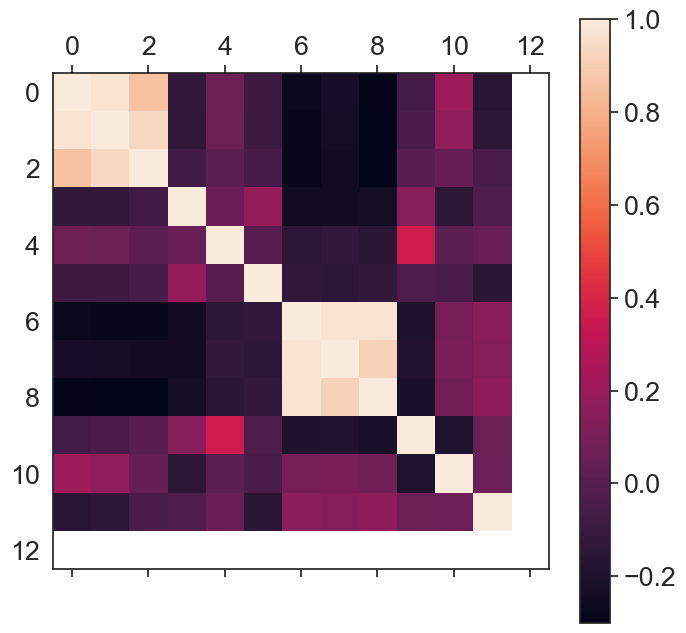

In [18]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(train.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

## Update Datas 

In [19]:
test = test.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [20]:
train = train.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [21]:
validation = validation.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [22]:
test.describe()

,temp_avg,prec,wd,ws,atmos_pres_avg,rh
count,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000
mean,21.144254,0.091971,238.932398,4.682899,1018.787122,65.270355
std,2.538478,0.987018,53.610970,2.233377,3.515182,11.442096
min,14.840000,0.000000,46.000000,1.000000,1001.800000,16.030000
25%,19.060000,0.000000,220.000000,3.600000,1016.690000,59.610000
50%,21.240000,0.000000,242.500000,4.100000,1018.350000,67.100000
75%,22.915000,0.000000,270.000000,5.700000,1020.825000,73.380000
max,30.830000,21.900000,360.000000,41.700000,1031.600000,91.080000


In [23]:
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", validation.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (3008, 6)
Validation dataset shape: (752, 6)
Test dataset shape: (959, 6)


In [24]:
train.corr()

,temp_avg,prec,wd,ws,atmos_pres_avg,rh
temp_avg,1.000000,-0.120273,0.059542,-0.083679,-0.272722,-0.048049
prec,-0.120273,1.000000,0.054333,0.189451,-0.240085,0.142776
wd,0.059542,0.054333,1.000000,-0.002588,-0.140491,0.362044
ws,-0.083679,0.189451,-0.002588,1.000000,-0.131442,-0.035096
atmos_pres_avg,-0.272722,-0.240085,-0.140491,-0.131442,1.000000,-0.198469
rh,-0.048049,0.142776,0.362044,-0.035096,-0.198469,1.000000


In [25]:
test.corr()

,temp_avg,prec,wd,ws,atmos_pres_avg,rh
temp_avg,1.000000,-0.103608,-0.081037,-0.142228,-0.374335,-0.049850
prec,-0.103608,1.000000,0.023900,0.042214,-0.239147,0.104439
wd,-0.081037,0.023900,1.000000,-0.016725,-0.073036,0.187872
ws,-0.142228,0.042214,-0.016725,1.000000,0.042293,-0.045449
atmos_pres_avg,-0.374335,-0.239147,-0.073036,0.042293,1.000000,-0.279648
rh,-0.049850,0.104439,0.187872,-0.045449,-0.279648,1.000000


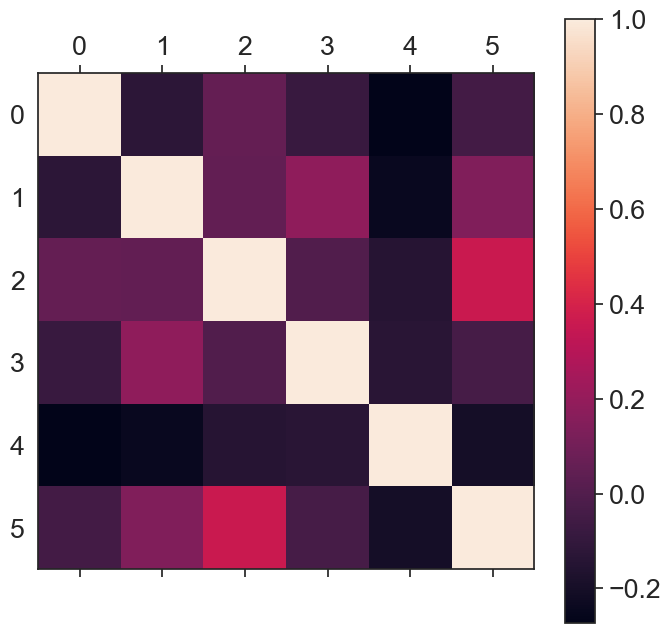

In [26]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(train.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

## Data Normalization  

In [27]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train)
x_test = scaler.transform(test)
x_validation = scaler.transform(validation)
scaler_filename = 'scaler_data'
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [28]:
print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(3008, 6)
(959, 6)
(752, 6)


In [29]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1])

In [30]:
print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(3008, 1, 6)
(959, 1, 6)
(752, 1, 6)


In [31]:
def autoencoder_model_GRU(X):
    inputs = Input(shape = (X.shape[1], X.shape[2]))
    L1 = GRU(32, activation = 'relu', return_sequences = True)(inputs)
    L2 = GRU(4, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = GRU(4, activation = 'relu', return_sequences = True)(L3)
    L5 = GRU(32, activation = 'relu', return_sequences = True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs = inputs, outputs = output)
    return model

In [32]:
model = autoencoder_model_GRU(x_train)
model.compile(optimizer = 'adamax', loss = 'mae', metrics = ['mae', 'mse', 'mape', 'msle', 'cosine_proximity'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 6)]            0         
_________________________________________________________________
gru (GRU)                    (None, 1, 32)             3840      
_________________________________________________________________
gru_1 (GRU)                  (None, 4)                 456       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 4)              120       
_________________________________________________________________
gru_3 (GRU)                  (None, 1, 32)             3648      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 6)              198   

In [33]:
dataframe_train = DataFrame()
dataframe_validation = DataFrame()

early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

for i in range(1):
    print('Fit model on training data...')
    start = time.time()
    epochs = 300
    batch_size = 32
    
    history = model.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, validation_data = (x_validation, x_validation), verbose = 0, callbacks=[early_stopping_callback]).history
    
    end = time.time()
    
    dataframe_train[str(i)] = history['loss']
    dataframe_validation[str(i)] = history['val_loss']
    
    print('Time to training model:', end - start)

Fit model on training data...
Time to training model: 305.48947644233704


In [34]:
print('Best MSE on validation set =', max(history['val_mae']))

Best MSE on validation set = 0.23092974722385406


In [35]:
loss = model.evaluate(x_train, x_train, verbose = 0)
for name, value in zip(model.metrics_names, loss): 
    print(name, value)

loss 0.03570276498794556
mae 0.03570276498794556
mse 0.005313219036906958
mape 160421.78125
msle 0.0026694796979427338
cosine_proximity 0.9895715117454529


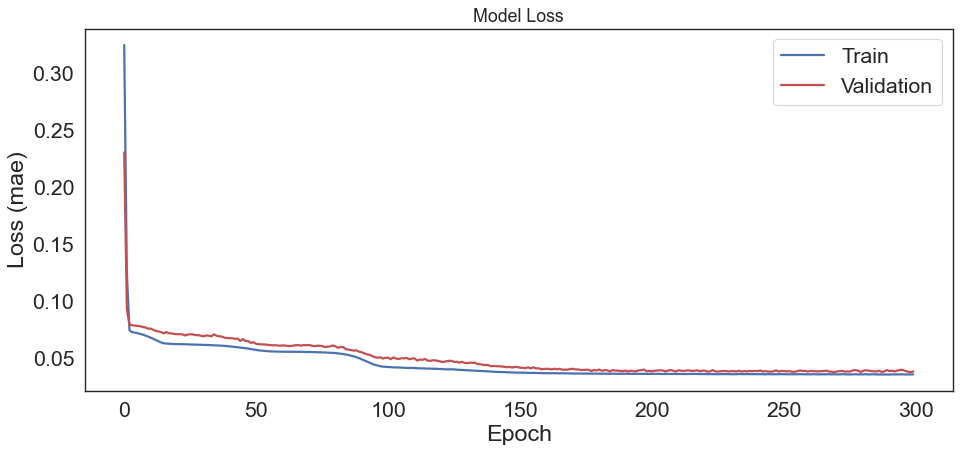

In [36]:
figure, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['loss'], 'b', label = 'Train', linewidth = 2)
ax.plot(history['val_loss'], 'r', label = 'Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize = 16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc = 'upper right')
plt.show()

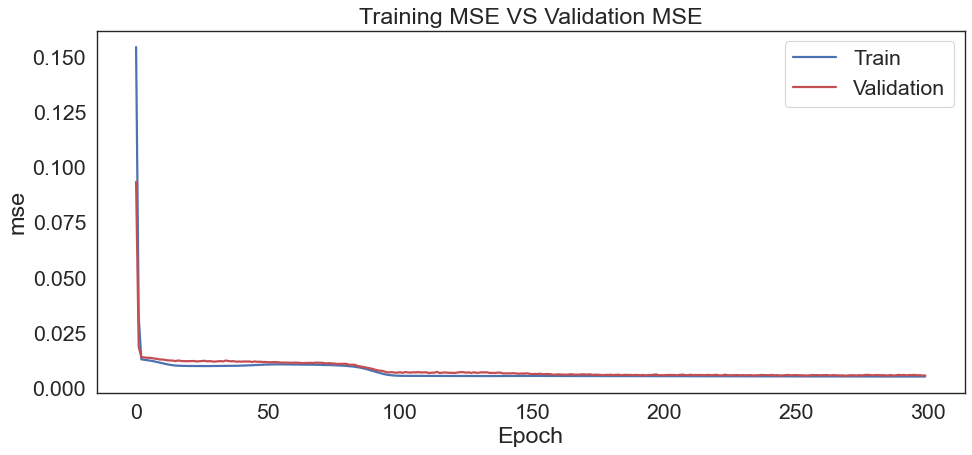

In [37]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['mse'], 'b', label = 'Train', linewidth = 2)
ax.plot(history['val_mse'], 'r', label = 'Validation', linewidth = 2)
ax.set_title('Training MSE VS Validation MSE')
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc = 'upper right')
plt.show()

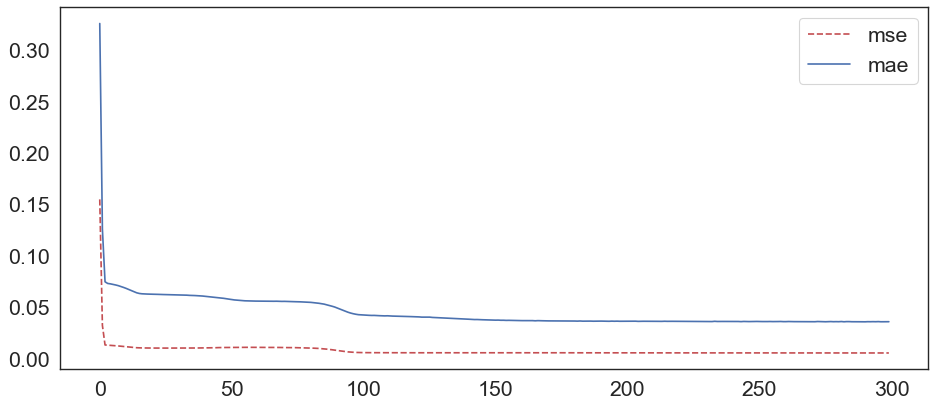

In [38]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['mse'], 'r--', label = 'mse')
ax.plot(history['mae'], 'b', label = 'mae')
ax.legend(loc = 'upper right')
plt.show()

## Distribution of Loss Function 

In [61]:
x_pred = model.predict(x_train)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns = train.columns)
x_pred.index = train.index

D:\TFG\Environment\TFG\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.4)

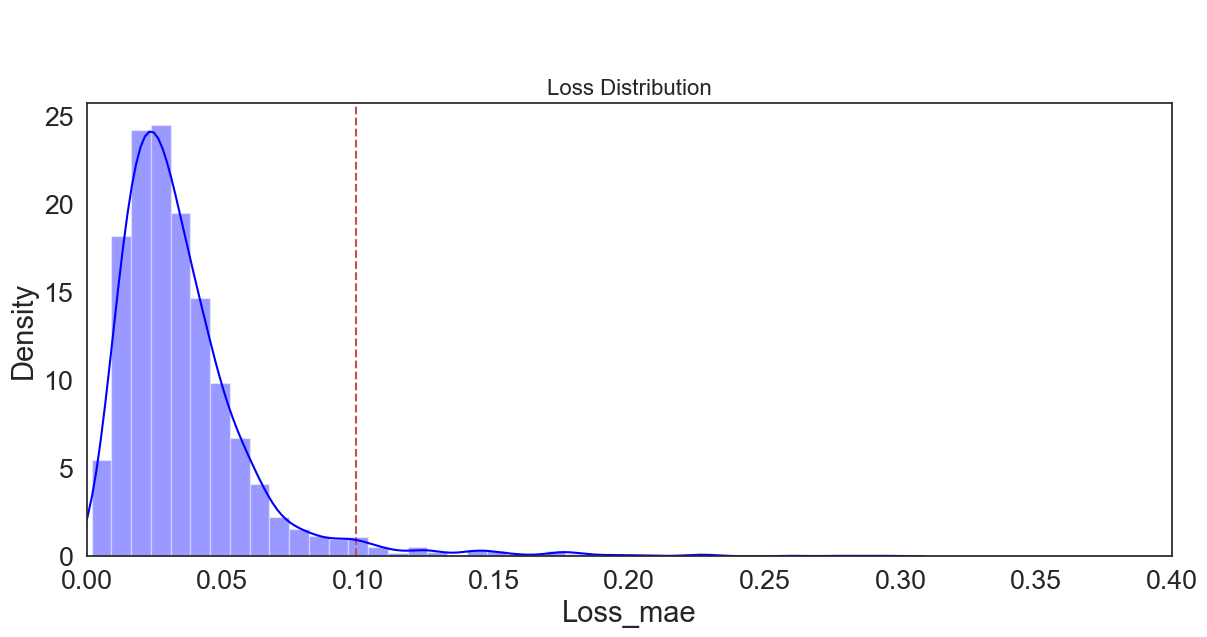

In [62]:
scored = pd.DataFrame(index = train.index)
Xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred - Xtrain), axis = 1)
plt.figure(figsize = (14,6), dpi = 100)
plt.title('Loss Distribution', fontsize = 16)
plt.axvline(0.09925221707013354, ls = '--', color = 'r')
plt.annotate('Threshold = 0.09925221707013354',
            xy = (0.06, 30), xycoords = 'data', fontsize = 14,
            horizontalalignment = 'center', verticalalignment = 'bottom')
sns.distplot(scored['Loss_mae'], bins = 40, kde = True, color = 'blue')
plt.xlim([0.0, .4])

## Test Predictions 

In [63]:
x_pred = model.predict(x_test)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns = test.columns)
x_pred.index = test.index

In [64]:
error_dataframe = pd.DataFrame(index = test.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])
error_dataframe['Reconstruction_error'] = np.mean(np.power(x_pred - Xtest, 2), axis = 1)
error_dataframe['True_class'] = test_fma
error_dataframe.head()

,Reconstruction_error,True_class
3832,0.004233,0
3833,0.007994,0
3834,0.005861,0
3835,0.005049,0
3836,0.003642,0


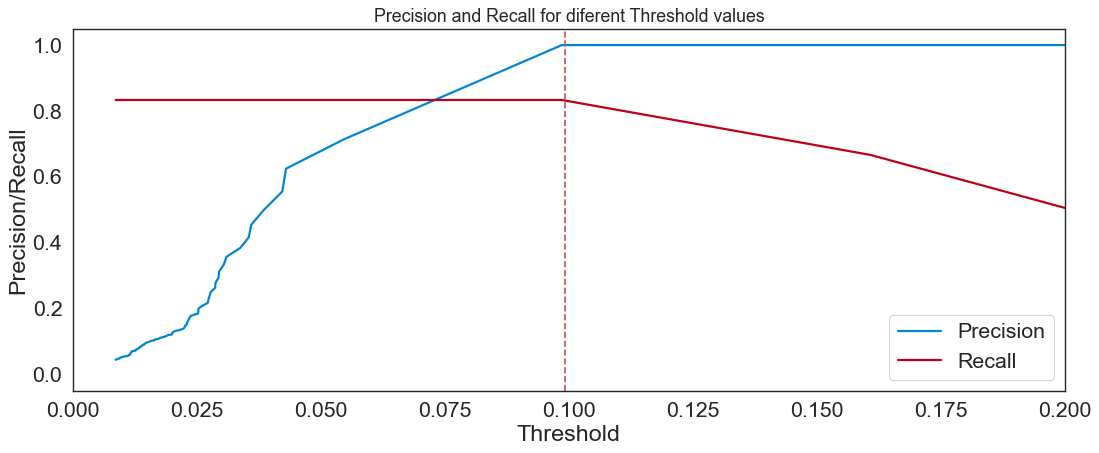

In [65]:
precision, recall, threshold = precision_recall_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(threshold, precision[1:], label = 'Precision', linewidth = 2)
ax.plot(threshold, recall[1:], label = 'Recall', linewidth = 2)
ax.set_title('Precision and Recall for diferent Threshold values', fontsize = 16)
ax.set_xlabel('Threshold')
ax.set_ylabel('Precision/Recall')
ax.set_xlim([0.0, 0.2])
ax.axvline(0.09925221707013354, ls = '--', color = 'r')
ax.legend(loc = 'lower right')
plt.show()

### ROC Curve Check 

In [66]:
false_pos_rate, true_pos_rate, threshold = roc_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

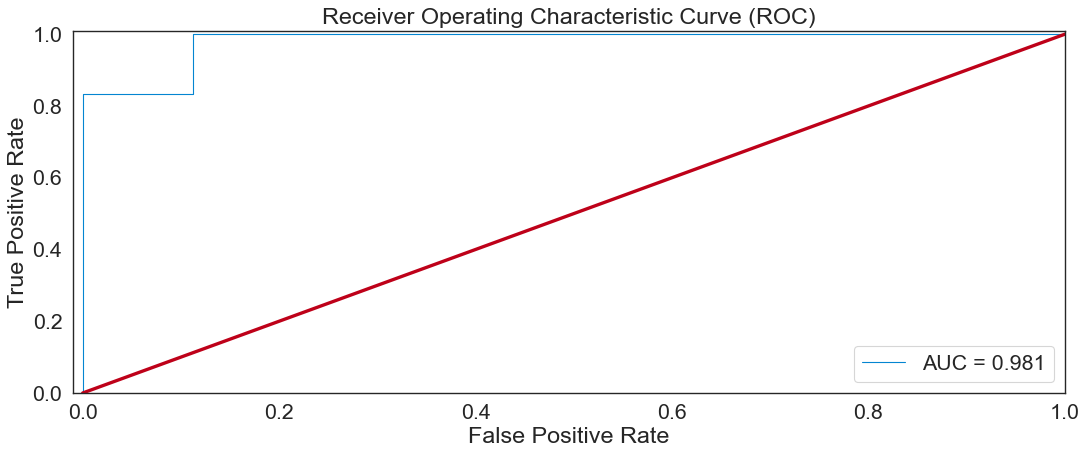

In [67]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(false_pos_rate, true_pos_rate, linewidth = 1, label = 'AUC = %0.3f'% roc_auc)
ax.plot([0,1], [0,1], linewidth = 3)
ax.set_title('Receiver Operating Characteristic Curve (ROC)')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.legend(loc = 'lower right')
plt.show()

### Recall VS Precision Thresholding 

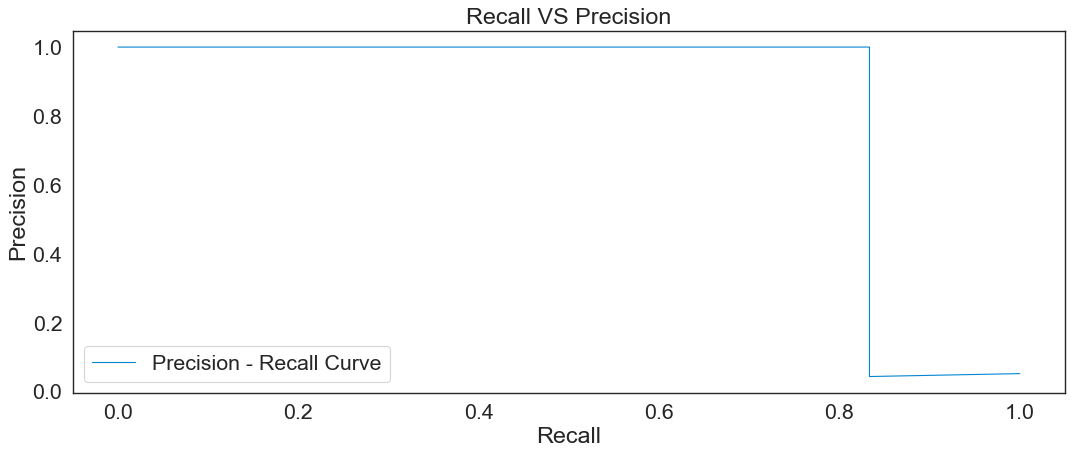

In [68]:
precision, recall, threshold = precision_recall_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(recall, precision, linewidth = 1, label = 'Precision - Recall Curve' )
ax.set_title('Recall VS Precision')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend(loc = 'lower left')
plt.show()

### Reconstruction Error VS Threshold Check 

In [69]:
threshold_fixed = 0.09925221707013354
groups = error_dataframe.groupby('True_class')

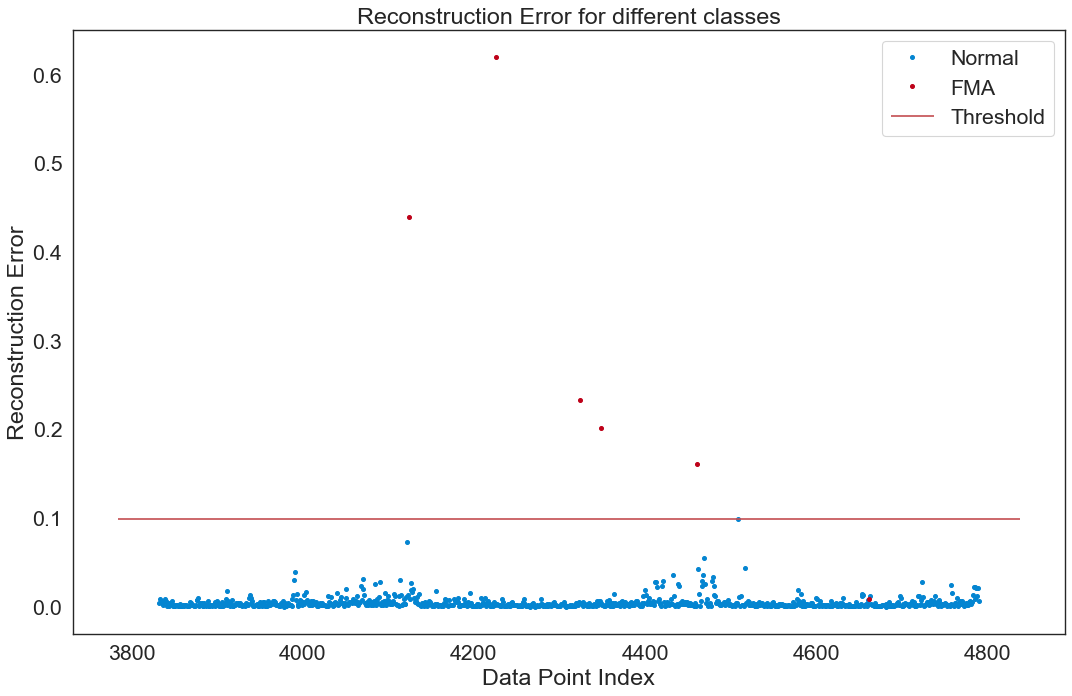

In [70]:
fig, ax = plt.subplots(figsize = (16, 10), dpi = 80)

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms = 3.5, linestyle = '', label = 'FMA' if name == 1 else 'Normal')

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors = 'r', zorder = 100, label = 'Threshold')
ax.set_title('Reconstruction Error for different classes')
ax.set_ylabel('Reconstruction Error')
ax.set_xlabel('Data Point Index')
ax.legend(loc = 'upper right')
plt.show()

### Confusion Matrix

In [71]:
pred_y = [1 if error > threshold_fixed else 0 for error in error_dataframe.Reconstruction_error.values]

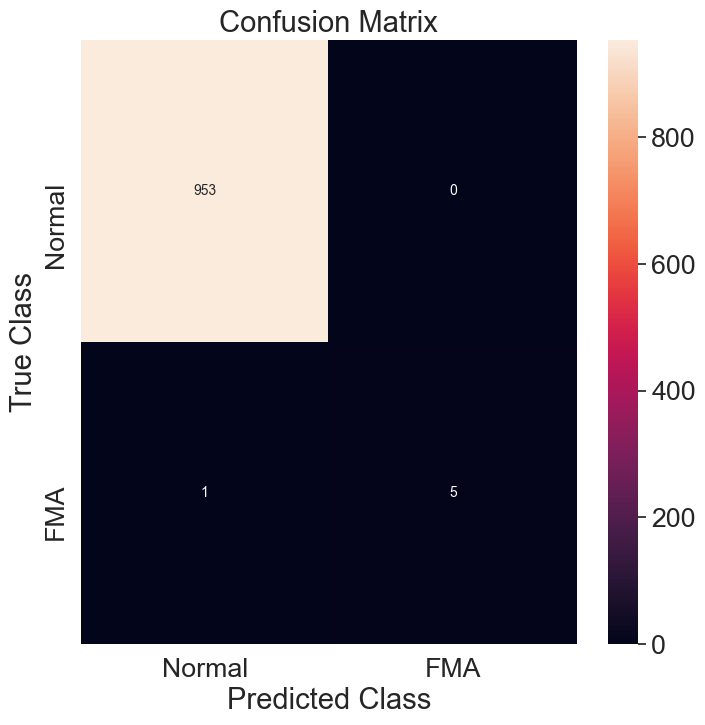

In [72]:
matrix = confusion_matrix(error_dataframe.True_class, pred_y)
fig, ax = plt.subplots(figsize = (8, 8), dpi = 100)
sns.heatmap(matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = 'd')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
plt.show()

### Reconstruction Error - Test Set

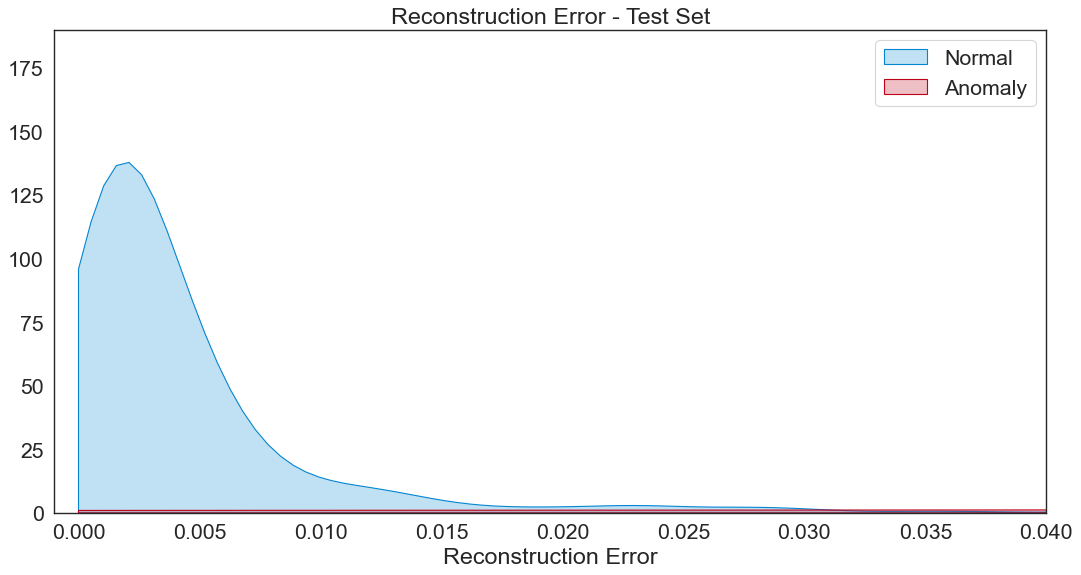

In [73]:
fig, ax = plt.subplots(figsize = (16, 8), dpi = 80)
sns.kdeplot(error_dataframe.Reconstruction_error[error_dataframe.True_class == 0], label = 'Normal', shade = True, clip = (0, 10))
sns.kdeplot(error_dataframe.Reconstruction_error[error_dataframe.True_class == 1], label = 'Anomaly', shade = True, clip = (0, 10))
ax.set_title('Reconstruction Error - Test Set')
ax.set_xlim([-0.001, 0.04])
ax.set_ylim([0, 190])
ax.set_xlabel('Reconstruction Error')
ax.set_ylabel('')
ax.legend(loc = 'upper right')
plt.show()

## Thresholds 

### Threshold with Max  

In [74]:
x_train_pred = model.predict(x_train)
train_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)
threshold_max = np.max(train_loss)
print("Reconstruction error threshold with max: ", threshold_max)

Reconstruction error threshold with max:  0.9982293006032705


### Threshold with Mean and Std

In [75]:
x_train_pred = model.predict(x_train)
train_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)
threshold_mean_std = np.mean(train_loss) + np.std(train_loss)
print("Reconstruction error threshold with mean and std: ", threshold_mean_std)

Reconstruction error threshold with mean and std:  0.09925221707013354


### Threshold Precision ∩ Recall

In [ ]:
def intersection_point():
    precision_points = np.array([[threshold[i],precision[i+1]] for i in range(len(precision[1:]))])
    recall_points = np.array([[threshold[i],recall[i+1]] for i in range(len(recall[1:]))])
    nrows, ncols = precision_points.shape
    dtype = {'names': ['f{}'.format(i) for i in range(ncols)], 'formats': ncols * [precision_points.dtype]}
    intersection = np.intersect1d(precision_points.view(dtype), recall_points.view(dtype))
    return intersection.view(precision_points.dtype).reshape(-1, ncols)

In [ ]:
threshold_precision_recall = intersection_point()[0][0]

In [ ]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}\n".format(ll))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred, target_names = LABELS))
    print("Fbeta Score(0.5):{:.3f}".format(fbeta_score(ytest, ypred, average="micro", beta=0.5)))

In [ ]:
threshold_fixed = [threshold_max, threshold_mean_std, threshold_precision_recall]

print('------------------------------------------------------------------------------')

for threshold in threshold_fixed: 
    pred_y = [1 if error > threshold else 0 for error in error_dataframe.Reconstruction_error.values]
    matrix = confusion_matrix(error_dataframe.True_class, pred_y)
    
    precision = precision_score(error_dataframe.True_class, pred_y, average = 'weighted')
    recall = recall_score(error_dataframe.True_class, pred_y, average = 'weighted')
    fbeta = fbeta_score(error_dataframe.True_class, pred_y, beta = 0.5)
    
    print('Result:\n')
    print('Precision Score = %.3f\nRecall Score = %.3f\nFbeta Score = %.3f\n' % (precision, recall, fbeta))
    print('Threshold fixed = %.3f' % threshold)
    print_stats(error_dataframe.True_class, pred_y)
    print('------------------------------------------------------------------------------')

### Historic 

In [81]:
#model.save("../../Historical/LaGomera/GRU_GOMERA.h5")

In [82]:
#with open('../../Historical/LaGomera/GRU_GOMERA.txt', 'wb') as file_pi:
#    pickle.dump(history, file_pi)